In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.linear_model import LinearRegression
from fill_data_gap_helpers import *

pd.set_option('display.max_rows', 8)
!

%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.ensemble import RandomForestClassifier

## Load data

In [3]:
path = 'lsff_estimated_data_plus_covariates.csv'

df = pd.read_csv(path)
df = df.drop(columns=['standard'])
df.columns = [i.replace(" ","_") for i in df.columns]

In [4]:
npar = df.parent_id.nunique()
parent_map = {i:j for (i,j) in zip(df.parent_id.unique(),np.random.choice(npar, size = npar, replace = False))}

In [5]:
df.parent_id = df.parent_id.map(parent_map)

In [6]:
def round_n(x, base=5):
    if np.isnan(x):
        return np.nan
    return base * round(x/base)

In [7]:
df.percent_of_population_eating_vehicle = [round_n(i, 20) for i in df.percent_of_population_eating_vehicle]

In [8]:
df.head()

,location_name,vehicle,nutrient,percent_of_population_eating_vehicle,percent_of_population_eating_industrially_produced_vehicle,percent_of_population_eating_fortified_vehicle,location_id,sodium,whole_grains,sdi,hh_salt,fao_maize_and_products,fao_rice_and_products,fao_wheat_and_products,fao_oil_all,parent_id
0,Angola,wheat flour,iron,NaN,NaN,NaN,168,0.981117,8.87061,0.464635,0.805634,415.0,80.0,256.0,282.0,5
1,Angola,wheat flour,zinc,NaN,NaN,NaN,168,0.981117,8.87061,0.464635,0.805634,415.0,80.0,256.0,282.0,5
2,Angola,wheat flour,folic acid,NaN,NaN,NaN,168,0.981117,8.87061,0.464635,0.805634,415.0,80.0,256.0,282.0,5
3,Angola,wheat flour,vitamin b12,NaN,NaN,NaN,168,0.981117,8.87061,0.464635,0.805634,415.0,80.0,256.0,282.0,5
4,Angola,wheat flour,vitamin b1,NaN,NaN,NaN,168,0.981117,8.87061,0.464635,0.805634,415.0,80.0,256.0,282.0,5


## Globals

In [9]:
estimation_vars = ['percent_of_population_eating_vehicle',
       'percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_fortified_vehicle']

In [10]:
nlocs = df.location_name.nunique()
loc_map = {i:j for (i,j) in zip(df.location_name.unique(),np.random.choice(nlocs, size = nlocs, replace = False))}

nvehs = df.vehicle.nunique()
vcl_map = {i:j for (i,j) in zip(df.vehicle.unique(),np.random.choice(nvehs, size = nvehs, replace = False))}

nnutrs = df.nutrient.nunique()
nut_map = {i:j for (i,j) in zip(df.nutrient.unique(),np.random.choice(nnutrs, size = nnutrs, replace = False))}

## Percent of population eating vehicle

In [11]:
def setupReg(df, vehicle):

    s = guess_mean_val(df, grouped_on = 'vehicle', cols = ['percent_of_population_eating_industrially_produced_vehicle',
                                                           'percent_of_population_eating_fortified_vehicle',
                                                           'sodium', 'whole_grains', 'sdi', 'hh_salt',
                                                           'fao_maize_and_products','fao_rice_and_products',
                                                           'fao_wheat_and_products', 'fao_oil_all'])

    s = s[(s.vehicle==vehicle)]

    s = s.drop(columns=['nutrient','vehicle'])

    s['percent_of_population_eating_industrially_produced_vehicle'] = s.groupby('location_name').transform('mean').percent_of_population_eating_industrially_produced_vehicle
    s['percent_of_population_eating_fortified_vehicle'] = s.groupby('location_name').transform('mean').percent_of_population_eating_fortified_vehicle

    s = s.drop_duplicates()
    locs = s.location_name.tolist()
    s = s.drop(columns=['location_name','location_id'])
    print(s.columns)
    s = s.drop_duplicates()
    
    X_full = np.array(s.drop(columns='percent_of_population_eating_vehicle'))
    y_full = np.array(s.percent_of_population_eating_vehicle)

    y = y_full[~np.isnan(y_full)]
    X = X_full[~np.isnan(y_full)]
    

    return X, y, X_full, y_full, locs

In [12]:
def runReg(X, y):
    # randomly hold out a selection
    N = y.shape[0]
    select = np.random.choice(N, size = N - 1, replace = False)

#     reg = LinearRegression().fit(X[select], y[select])
#     reg = ElasticNet(max_iter=5_000, tol = 1.5e-3).fit(X[select], y[select])
    reg = RandomForestClassifier(max_depth=2, random_state=0).fit(X[select], y[select])
    
    holdout = np.array([i for i in range(N) if i not in select])
    preds = reg.predict(X[holdout])
    
    return holdout, preds

In [13]:
def plotReg(preds, holdout, vehicle):
    plt.scatter(y[holdout], preds)

    l,r,b,t = plt.axis()
    lb = min(0,l,b)
    ub = max(100,r,t)
    plt.plot([lb,ub], [lb,ub], 'k--')

    plt.title(f"out of sample validation: \npct of population that eats {vehicle}", fontsize = 15)

In [14]:
import matplotlib.backends.backend_pdf

In [15]:
checkCovariance = pd.DataFrame(X)

NameError: name 'X' is not defined

In [ ]:
checkCovariance.columns = ['percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_fortified_vehicle', 'sodium',
       'whole_grains', 'sdi', 'hh_salt', 'fao_maize_and_products',
       'fao_rice_and_products', 'fao_wheat_and_products', 'fao_oil_all',
       'parent_id']
checkCovariance['y'] = y

In [16]:
# fig, ax = plt.subplots(figsize=(8,8))
# cax = ax.matshow(checkCovariance.corr())

# ax.set_xticks(np.arange(len(checkCovariance.columns)))
# ax.set_yticks(np.arange(len(checkCovariance.columns)))
# # ... and label them with the respective list entries
# # ax.set_xticklabels(checkCovariance.columns)
# ax.set_yticklabels(checkCovariance.columns)
# ax.set_xticklabels(checkCovariance.columns)

# plt.setp(ax.get_xticklabels(), rotation=45, ha="left",
#          rotation_mode="anchor")

# cbar = fig.colorbar(cax)
# # ax.set_yticklabels(alpha)

Index(['percent_of_population_eating_vehicle',
       'percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_fortified_vehicle', 'sodium',
       'whole_grains', 'sdi', 'hh_salt', 'fao_maize_and_products',
       'fao_rice_and_products', 'fao_wheat_and_products', 'fao_oil_all',
       'parent_id'],
      dtype='object')


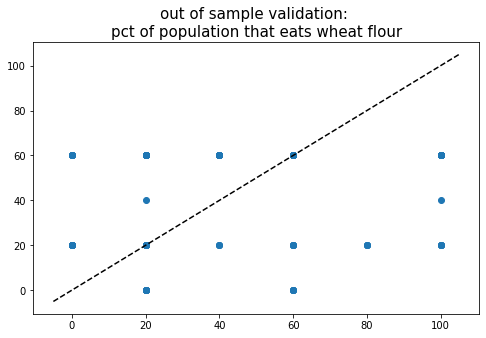

average error: 29.70
average clipped err: 29.70
Index(['percent_of_population_eating_vehicle',
       'percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_fortified_vehicle', 'sodium',
       'whole_grains', 'sdi', 'hh_salt', 'fao_maize_and_products',
       'fao_rice_and_products', 'fao_wheat_and_products', 'fao_oil_all',
       'parent_id'],
      dtype='object')


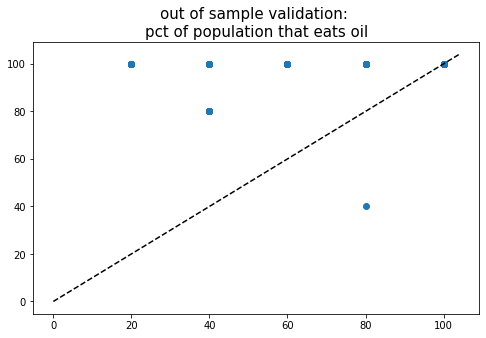

average error: 23.76
average clipped err: 23.76
Index(['percent_of_population_eating_vehicle',
       'percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_fortified_vehicle', 'sodium',
       'whole_grains', 'sdi', 'hh_salt', 'fao_maize_and_products',
       'fao_rice_and_products', 'fao_wheat_and_products', 'fao_oil_all',
       'parent_id'],
      dtype='object')


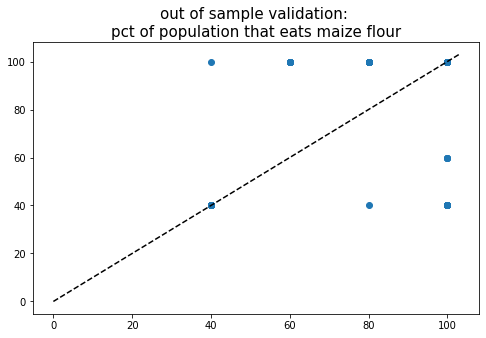

average error: 15.64
average clipped err: 15.64
Index(['percent_of_population_eating_vehicle',
       'percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_fortified_vehicle', 'sodium',
       'whole_grains', 'sdi', 'hh_salt', 'fao_maize_and_products',
       'fao_rice_and_products', 'fao_wheat_and_products', 'fao_oil_all',
       'parent_id'],
      dtype='object')


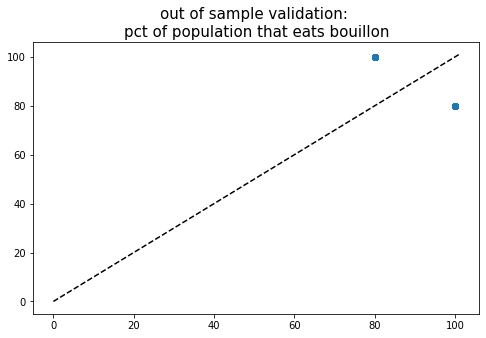

average error: 20.00
average clipped err: 20.00
Index(['percent_of_population_eating_vehicle',
       'percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_fortified_vehicle', 'sodium',
       'whole_grains', 'sdi', 'hh_salt', 'fao_maize_and_products',
       'fao_rice_and_products', 'fao_wheat_and_products', 'fao_oil_all',
       'parent_id'],
      dtype='object')


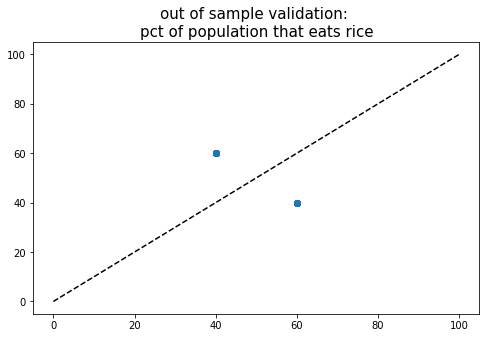

average error: 20.00
average clipped err: 20.00
avg overall error: 21.82
avg overall clipped error: 21.82


In [17]:
save_path = 'pct_eating_vehicle.pdf'
pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)


use_logit = False
total_err = 0
total_clipped_err = 0
for vehicle in ['wheat flour', 'oil', 'maize flour', 'bouillon', 'rice']:
    X, y, X_full, y_full, locs = setupReg(df, vehicle)

    holdout, preds = runReg(X,y)
    for i in range(100):
        a, b = runReg(X,y)
        holdout = np.concatenate((holdout, a))
        preds = np.concatenate((preds, b))
    
    fig = plt.figure(figsize=(8,5))
    plotReg(preds, holdout, vehicle)
    plt.show()
    pdf.savefig(fig)
    
    err = sum(np.abs(y[holdout] - preds)) / len(holdout)
    total_err += err
    print(f'average error: {err:0.2f}')
    
    clipped_err = sum(np.abs(y[holdout] - np.clip(preds, 0, 100))) / len(holdout)
    total_clipped_err += clipped_err
    print(f'average clipped err: {clipped_err:0.2f}')

pdf.close()
print(f'avg overall error: {total_err/5:0.2f}')
print(f'avg overall clipped error: {total_clipped_err/5:0.2f}')

In [25]:
df[['location_name','vehicle','percent_of_population_eating_vehicle']].drop_duplicates().groupby('vehicle').count()

,location_name,percent_of_population_eating_vehicle
vehicle,,
bouillon,7,3
maize flour,17,8
oil,25,18
rice,3,2
salt,3,1
wheat flour,25,17


In [13]:
## generate estimates

In [14]:
def estimate_nans(df, vehicle, use_logit, clip = True):
    
    # format for regression
    X, y, X_full, y_full, locs = setupReg(df, vehicle, use_logit)
    
    # run regression
    reg = LinearRegression().fit(X, y)
    
    # predict out
    preds = reg.predict(X_full)
    
    # populate missings with estimates
    y_full[np.isnan(y_full)] = preds[np.isnan(y_full)] 
    
    if use_logit:
        y_full = (expit(y_full) + shift) * 100
    
    if clip:
        y_full = np.clip(y_full, 0, 100)
    
    return pd.DataFrame({'location_name':locs,'vehicle':vehicle,'percent_of_population_eating_vehicle':y_full})

In [18]:
use_logit = False
vehicle = "wheat flour"
X, y, X_full, y_full, locs = setupReg(df, vehicle, use_logit)

In [34]:
reg = LinearRegression().fit(X, y)
preds = reg.predict(X_full)

In [43]:
reg.coef_

array([ 2.98663434e-01,  1.26201535e+00,  5.91713522e+00,  2.10634555e-01,
       -8.58135855e+01,  1.54806794e+01, -5.44527242e-02,  2.98031195e-03,
        9.39870688e-02,  6.74298455e-02])

In [44]:
reg.intercept_

6.419514880039912

In [45]:
reg.coef_.shape

(10,)

In [46]:
reg.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [47]:
from sklearn.metrics import mean_squared_error

In [50]:
mean_squared_error(y, reg.predict(X))

224.82240876583887

In [51]:
y

array([62.35      , 52.3       , 94.46363636, 54.7       ,  0.58      ,
       28.        , 83.2       , 36.58      , 66.76666667,  5.        ,
       27.96666667, 49.05      , 97.33333333, 14.75      , 51.5       ,
       11.2       , 21.93      ])

In [53]:
rp = reg.predict(X)

In [58]:
np.mean([i**2 for i in (y - rp)])

224.82240876583887

In [38]:
compare = pd.DataFrame({'location_name':locs,'vehicle':vehicle,'estimates':preds,'data':y_full})

In [41]:
compare['error'] = np.abs(compare.data - compare.estimates)

In [42]:
compare

,location_name,vehicle,estimates,data,error
0,Angola,wheat flour,38.200736,NaN,NaN
1,Bangladesh,wheat flour,42.786478,62.350000,19.563522
2,Burkina Faso,wheat flour,28.989654,52.300000,23.310346
3,Cameroon,wheat flour,88.597117,94.463636,5.866519
...,...,...,...,...,...
21,Sudan,wheat flour,68.367950,NaN,NaN
22,United Republic of Tanzania,wheat flour,48.608870,51.500000,2.891130
23,Uganda,wheat flour,15.647225,11.200000,4.447225
24,Viet Nam,wheat flour,23.687909,21.930000,1.757909


In [20]:
estimates = pd.concat([estimate_nans(df, vehicle, use_logit = False, clip = True)
                       for vehicle in ['wheat flour', 'oil', 'maize flour', 'bouillon', 'rice']])

In [21]:
estimates

,location_name,vehicle,percent_of_population_eating_vehicle
0,Angola,wheat flour,38.200736
1,Bangladesh,wheat flour,62.350000
2,Burkina Faso,wheat flour,52.300000
3,Cameroon,wheat flour,94.463636
...,...,...,...
6,Nigeria,bouillon,98.727280
0,Ghana,rice,65.746433
1,India,rice,50.000000
2,Nigeria,rice,67.350000


In [24]:
estimates = estimates.rename(columns={'percent_of_population_eating_vehicle':'estimated'})

In [30]:
compare = df[['location_name','vehicle','percent_of_population_eating_vehicle']].drop_duplicates()

compare = compare.merge(estimates, on = ['location_name','vehicle'], how = 'outer')

In [32]:
compare['error'] = np.abs(compare.percent_of_population_eating_vehicle - compare.estimated)

In [33]:
compare

,location_name,vehicle,percent_of_population_eating_vehicle,estimated,error
0,Angola,wheat flour,NaN,38.200736,NaN
1,Angola,oil,NaN,91.912645,NaN
2,Angola,maize flour,NaN,27.751148,NaN
3,Bangladesh,wheat flour,62.35,62.350000,0.0
...,...,...,...,...,...
76,Uganda,oil,89.90,89.900000,0.0
77,Uganda,maize flour,91.80,91.800000,0.0
78,Viet Nam,wheat flour,21.93,21.930000,0.0
79,Viet Nam,oil,54.50,54.500000,0.0


In [59]:
compare

,location_name,vehicle,estimates,data,error
0,Angola,wheat flour,38.200736,NaN,NaN
1,Bangladesh,wheat flour,42.786478,62.350000,19.563522
2,Burkina Faso,wheat flour,28.989654,52.300000,23.310346
3,Cameroon,wheat flour,88.597117,94.463636,5.866519
...,...,...,...,...,...
21,Sudan,wheat flour,68.367950,NaN,NaN
22,United Republic of Tanzania,wheat flour,48.608870,51.500000,2.891130
23,Uganda,wheat flour,15.647225,11.200000,4.447225
24,Viet Nam,wheat flour,23.687909,21.930000,1.757909


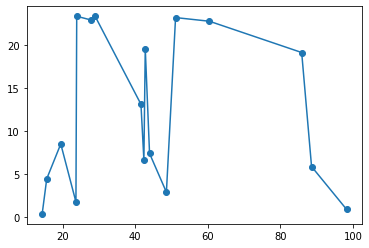

In [67]:
compare = compare.sort_values('estimates')
compare = compare.dropna()

plt.plot(compare.estimates, compare.error)
plt.scatter(compare.estimates, compare.error)
plt.show()

In [16]:
fname = 'percent_of_population_eating_vehicle_estimates.csv'
estimates.to_csv(fname, index = False)

In [17]:
estimates

,location_name,vehicle,percent_of_population_eating_vehicle
0,Angola,wheat flour,38.200736
1,Bangladesh,wheat flour,62.350000
2,Burkina Faso,wheat flour,52.300000
3,Cameroon,wheat flour,94.463636
...,...,...,...
6,Nigeria,bouillon,98.727280
0,Ghana,rice,65.746433
1,India,rice,50.000000
2,Nigeria,rice,67.350000


In [18]:
df[(df.percent_of_population_eating_vehicle.isna()) & (df.percent_of_population_eating_industrially_produced_vehicle.notna())]

,location_name,vehicle,nutrient,percent_of_population_eating_vehicle,percent_of_population_eating_industrially_produced_vehicle,percent_of_population_eating_fortified_vehicle,location_id,sodium,whole_grains,sdi,hh_salt,fao_maize_and_products,fao_rice_and_products,fao_wheat_and_products,fao_oil_all
250,Nigeria,salt,iron,NaN,93.0,0.0,214,0.908433,8.865245,0.460839,0.935323,315.0,266.0,195.0,284.0
251,Nigeria,bouillon,iron,NaN,61.5,0.0,214,0.908433,8.865245,0.460839,0.935323,315.0,266.0,195.0,284.0
252,Nigeria,bouillon,zinc,NaN,61.5,0.0,214,0.908433,8.865245,0.460839,0.935323,315.0,266.0,195.0,284.0
253,Nigeria,bouillon,folic acid,NaN,61.5,0.0,214,0.908433,8.865245,0.460839,0.935323,315.0,266.0,195.0,284.0
254,Nigeria,bouillon,vitamin a,NaN,61.5,0.0,214,0.908433,8.865245,0.460839,0.935323,315.0,266.0,195.0,284.0
347,Nigeria,salt,folic acid,NaN,93.0,0.0,214,0.908433,8.865245,0.460839,0.935323,315.0,266.0,195.0,284.0


In [19]:
estimates[(estimates.location_name=="Nigeria") & (estimates.vehicle.isin(['salt','bouillon']))]

,location_name,vehicle,percent_of_population_eating_vehicle
6,Nigeria,bouillon,98.72728
